# DS Model using LSTM

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [2]:
HYPER_PARAMS = {'n_epochs': 1,
                'use_case': 3,
                'd_sample': 1,
                'gauss_sigma': 10,
                'feature_range_low': -1,
                'feature_range_high': 1,
                'n_steps': 50,
                'n_features': 1,
                'n_lstm_units_1': 50,
                'alpha_1': 0.1,
                'n_lstm_units_2': 20,
                'alpha_2': 0.1,
                'n_dense_units': 10,
                'activation_output_layer': 'tanh',
                'dropout': 0.2,
                'learning_rate': 0.001,
                'optimizer': 'Adam',
                'metric': 'mae',
                'loss_funcs': ['mse'],
                'lambda_mse': 1,
                }

### Prepare Training/Validation/Test Data
Training data can be modified to account for specific use cases. The prepare_data function is fed with the required profiles and will preprocess the sequence. Three use cases are predefined:
###### 1. Use Case: Train and Test data are built from equal profiles
 The purpose is to find out if the network is able to accurately reproduce the seen profiles
###### 2. Use Case: Train and Test data are of equal value range but different profiles
The purpose is to find out if the network can abstract onto unseen profiles with similar characteristics
###### 3. Use Case: Train and Test data are of different distributions
The purpose is to find out if the network can abstract onto new value ranges and unseen profiles

In [3]:
train_profiles_usecase_1 = ['Profile 10A']
train_profiles_usecase_2 = ['Profile 10A', 'Profile 10A', 'Profile 10A', 'Profile 10A', 'Profile 10A', 'Profile 10A',
                            'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618','Profile 10A Run 040618', 
                            'Profile 10A Run 080618', 'Profile 10A Run 080618', 'Profile 10A Run 080618', 'Profile 10A Run 080618', 'Profile 10A Run 080618', 'Profile 10A Run 080618',
                            'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 'Profile 10A Run 040618', 
                            'Profile 10A Run 070618_3', 'Profile 10A Run 070618_3', 'Profile 10A Run 070618_3', 'Profile 10A Run 070618_3', 'Profile 10A Run 070618_3', 'Profile 10A Run 070618_3',
                            'Profile 10A Run 070618_2', 'Profile 10A Run 070618_2', 'Profile 10A Run 070618_2', 'Profile 10A Run 070618_2', 'Profile 10A Run 070618_2','Profile 10A Run 070618_2',
                            'Profile 10A Run 070618', 'Profile 10A Run 070618', 'Profile 10A Run 070618', 'Profile 10A Run 070618', 'Profile 10A Run 070618','Profile 10A Run 070618','Profile 10A Run 070618']
train_profiles_usecase_3 = ['Profile 10A']

val_profiles_usecase_1 = ['Profile 10A']
val_profiles_usecase_2 = ['Profile 10A Run 040618']
val_profiles_usecase_3 = ['Profile 10A Run 040618']

test_profiles_usecase_1 = ['Profile 10A']
test_profiles_usecase_2 = ['Profile 10A Run 070618']
test_profiles_usecase_3 = ['Profile -10A']

if HYPER_PARAMS['use_case'] == 1:
    X_train, y_train, scalers_train = util.prepare_current_input(HYPER_PARAMS, train_profiles_usecase_1, 0, 4)
    X_validation, y_validation, scalers_validation = util.prepare_current_input(HYPER_PARAMS, val_profiles_usecase_1, 0, 4)
    X_test, y_test, scalers_test = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_1, 0, 4)
elif HYPER_PARAMS['use_case'] == 2:
    X_train, y_train, scalers_train = util.prepare_current_input(HYPER_PARAMS, train_profiles_usecase_2, 0, 4)
    X_validation, y_validation, scalers_validation = util.prepare_current_input(HYPER_PARAMS, val_profiles_usecase_2, 0, 4)
    X_test, y_test, scalers_test = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_2, 0, 4)
elif HYPER_PARAMS['use_case'] == 3:
    X_train, y_train, scalers_train = util.prepare_current_input(HYPER_PARAMS, train_profiles_usecase_3, 0, 4)
    X_validation, y_validation, scalers_validation = util.prepare_current_input(HYPER_PARAMS, val_profiles_usecase_3, 0, 4)
    X_test, y_test, scalers_test = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_3, 0, 4)

scalers = scalers_train, scalers_validation, scalers_test 
# scalers shape: ((train_cur, train_volt), (val_cur, val_volt), (test_cur, test_volt))

Input: (3000, 50, 1) 
Output/Label: (3000, 1)
Input: (3300, 50, 1) 
Output/Label: (3300, 1)
Input: (3200, 50, 1) 
Output/Label: (3200, 1)


### Prepare Data for Use Cases

In [4]:
test_profiles_usecase_1 = ['Profile 10A']
test_profiles_usecase_2 = ['Profile 10A 3x']
test_profiles_usecase_3 = ['Profile -10A']

X_test_1, y_test_1, scalers_test_1 = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_1, 0, 4)
X_test_2, y_test_2, scalers_test_2 = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_2, 0, 4)
X_test_3, y_test_3, scalers_test_3 = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_3, 0, 4)
scalers_usecases = scalers_train, scalers_test_1, scalers_test_2, scalers_test_3 

Input: (3000, 50, 1) 
Output/Label: (3000, 1)
Input: (6200, 50, 1) 
Output/Label: (6200, 1)
Input: (3200, 50, 1) 
Output/Label: (3200, 1)


### Initialize and Train Model

In [5]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 8s 84ms/step - loss: 0.0958 - mse: 0.0958 - mae: 0.2301
Training time: 8.103s


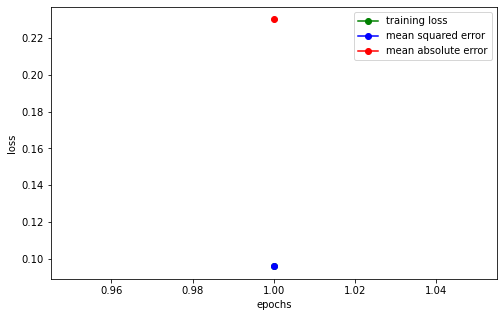

INFO:tensorflow:Assets written to: ../../../models/DS/7217\assets


In [6]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/DS/' + str(MODEL_ID))
np.save('../../../models/DS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

94/94 [==============================] - 3s 33ms/step
Prediction time on Training Set:  3.167s
104/104 [==============================] - 4s 35ms/step
Prediction time on Validation Set:  3.632s
100/100 [==============================] - 3s 33ms/step
Prediction time on Test Set:  3.376s
###########################################################
            Training    Validation     Test
--------  ----------  ------------  -------
MSE (μV)     41.4          31.5     68
MAE (V)       0.0048        0.0036   0.0075
MaxE (V)      0.0162        0.0162   0.0162
###########################################################


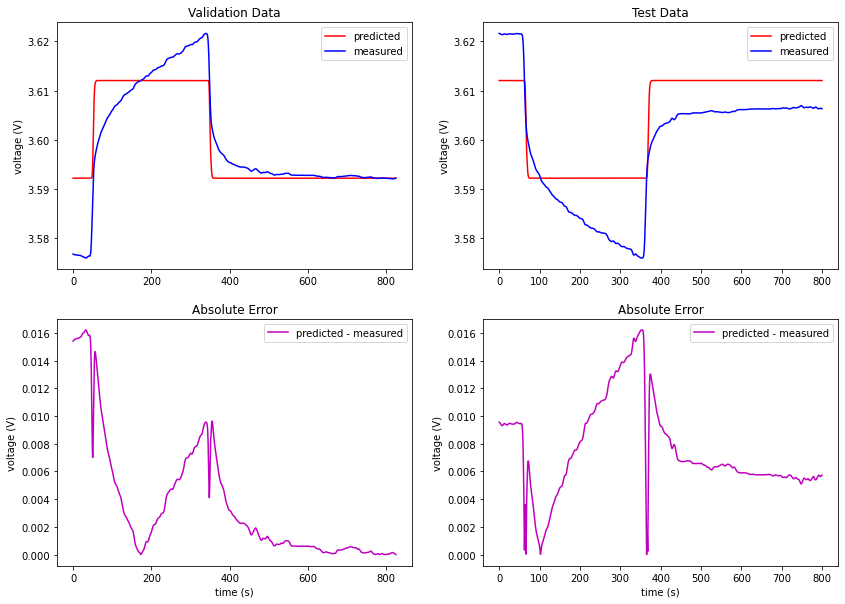

In [7]:
yhat_train_unscaled, _, _, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/DS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-validation&test_profiles.png')

In [8]:
lstm.test_usecases(X_train, y_train, X_test_1, y_test_1, X_test_2, y_test_2, X_test_3, y_test_3, scalers_train)

94/94 [==============================] - 3s 33ms/step
Prediction time on Training Set:  3.163s
94/94 [==============================] - 3s 32ms/step
Prediction time on Use Case 1:  3.065s
194/194 [==============================] - 6s 32ms/step
Prediction time on Use Case 2:  6.224s
100/100 [==============================] - 3s 32ms/step
Prediction time on Use Case 3:  3.249s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)     41.4          41.4          85.4          68
MAE (V)       0.0048        0.0048        0.0077        0.0075
MaxE (V)      0.0162        0.0162        0.0227        0.0162
##############################################################
